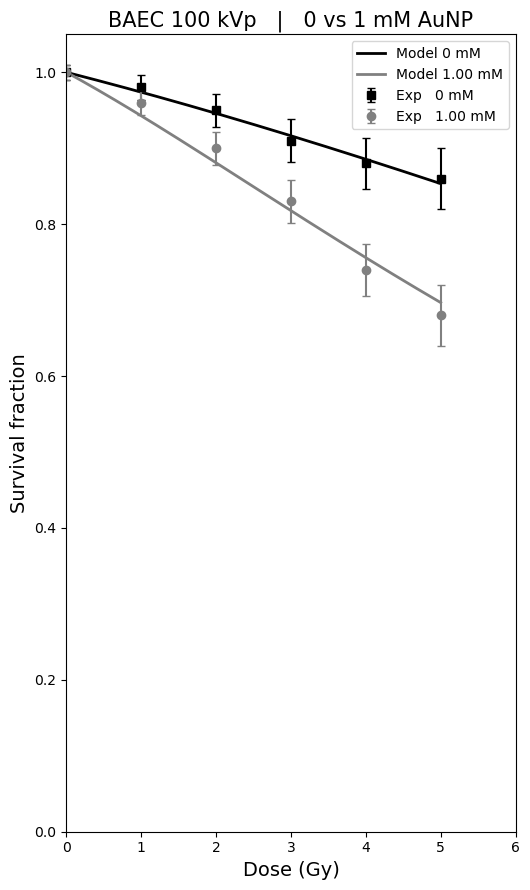

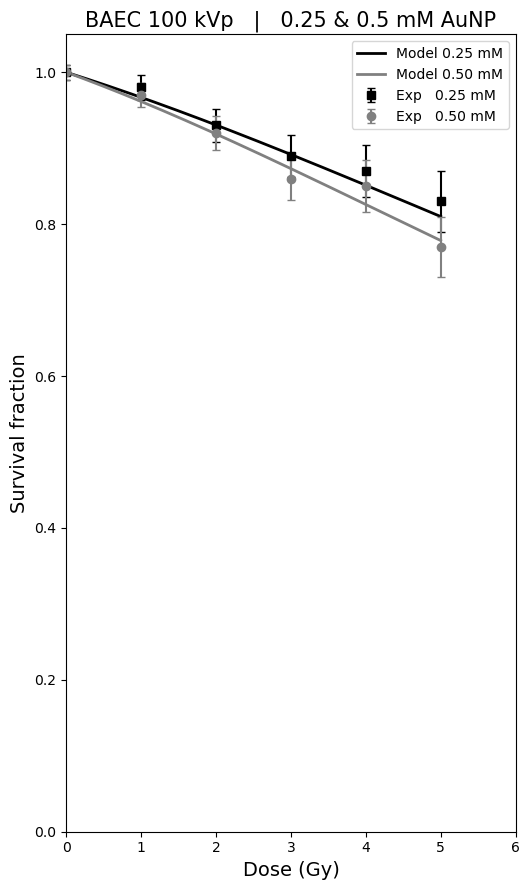


=== 0 mM  (LQ) ==================================
 Dose (Gy)  SF_exp  SF_model  % diff
       0.0    1.00    1.0000     0.0
       1.0    0.98    0.9738    -0.6
       2.0    0.95    0.9459    -0.4
       3.0    0.91    0.9164     0.7
       4.0    0.88    0.8855     0.6
       5.0    0.86    0.8534    -0.8

=== 0.25 mM (mixed, trunc) ==================================
 Dose (Gy)  SF_exp  SF_model  % diff
       0.0    1.00    1.0000     0.0
       1.0    0.98    0.9669    -1.3
       2.0    0.93    0.9306     0.1
       3.0    0.89    0.8917     0.2
       4.0    0.87    0.8513    -2.1
       5.0    0.83    0.8101    -2.4

=== 0.50 mM (mixed, trunc) ==================================
 Dose (Gy)  SF_exp  SF_model  % diff
       0.0    1.00    1.0000     0.0
       1.0    0.97    0.9615    -0.9
       2.0    0.92    0.9187    -0.1
       3.0    0.86    0.8731     1.5
       4.0    0.85    0.8259    -2.8
       5.0    0.77    0.7785     1.1

=== 1.00 mM (complete 2nd) ==================

In [6]:
# ---------------------------------------------------------------
# BAEC survival – 100 kVp – σ-LEM hierarchy
# (0 / 0.25 / 0.5 / 1.0 mM AuNP)
# First-order curves include the Z ≥ –1/σ truncation factor
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erfc                         # scalar erfc
v_erfc = np.vectorize(erfc)                   # vectorised for arrays

# ------------ 1. Fixed parameters ---------------------------------
alpha, beta = 0.0252, 0.00130                 # LQ for bare BAEC
Kc          = 2.11                            # cascade constant (100 kVp)

# ------------ 2. Digitised experimental points --------------------
exp = {
    0.00: np.array([(0, 1.00), (1, 0.98), (2, 0.95),
                    (3, 0.91), (4, 0.88), (5, 0.86)]),
    0.25: np.array([(0, 1.00), (1, 0.98), (2, 0.93), (3, 0.89),
                    (4, 0.87), (5, 0.83)]),
    0.50: np.array([(0, 1.00), (1, 0.97), (2, 0.92), (3, 0.86),
                    (4, 0.85), (5, 0.77)]),
    1.00: np.array([(0, 1.00), (1, 0.96), (2, 0.90), (3, 0.83),
                    (4, 0.74), (5, 0.68)])
}

def _err(arr):                                # simple linear error bars
    d = arr[:, 0]
    return 0.01 + (d - d.min()) / (d.max() - d.min()) * 0.03

errs = {c: _err(arr) for c, arr in exp.items()}

# ------------ 3. σ(c) and model functions -------------------------
def sigma(c):                                 # width ← concentration
    return np.sqrt(2 * np.log1p(Kc * c))


def _trunc_factor(d, s):
    """
    𝔽(D₀; α, β, σ) = erfc( … ) / erfc(–1/(σ√2))
    Removes the Z < –1/σ slice created by the first-order expansion.
    """
    Aroot = np.sqrt(1 + 2 * beta * s**2 * d**2)
    shift = (-1 / s) + (s * d * (alpha + 2 * beta * d)) / (1 + 2 * beta * s**2 * d**2)
    num   = v_erfc(Aroot / np.sqrt(2) * shift)
    den   = erfc(-1 / (s * np.sqrt(2)))       # *** minus sign matters ***
    return num / den


def S_LQ(d):                                  # reference (0 mM)
    return np.exp(-alpha * d - beta * d**2)


# ----- first-order variance-only WITH truncation ------------------
def S_var_trunc(d, c):
    s   = sigma(c)
    Den = 1 + 2 * beta * s**2 * d**2
    Num = -alpha * d - beta * d**2 + (alpha**2 * s**2 * d**2) / (2 * Den)
    S   = np.exp(Num) / np.sqrt(Den)
    return S * _trunc_factor(d, s)


# ----- first-order mixed (α → α⋆) WITH truncation -----------------
def S_mix_trunc(d, c):
    s   = sigma(c)
    a_  = alpha + 2 * beta * d                # α⋆
    Den = 1 + 2 * beta * s**2 * d**2
    Num = -alpha * d - beta * d**2 + (a_ * s * d)**2 / (2 * Den)
    S   = np.exp(Num) / np.sqrt(Den)
    return S * _trunc_factor(d, s)


# ----- complete second-order (paper Eq. 34, μ = 0) ----------------
def S_second(d, c):
    s2 = sigma(c) ** 2
    Den = 1 + s2 * d * (alpha + 4 * beta * d)
    Num = -alpha * d - beta * d**2 + s2 * d**2 * (alpha + 2 * beta * d)**2 / (2 * Den)
    return np.exp(Num) / np.sqrt(Den)


# mapping: concentration → appropriate model
model = {0.00: lambda d, c: S_LQ(d),
         0.25: lambda d, c: S_mix_trunc(d, c),
         0.50: lambda d, c: S_mix_trunc(d, c),
         1.00: lambda d, c: S_second(d, c)}

# ------------ 4. Plotting helper ----------------------------------
D = np.linspace(0, 5, 301)                     # high-resolution dose axis

def panel(concs, title, outfile):
    """Draw one comparison panel and save it."""
    plt.figure(figsize=(5.4, 9.0))
    for c, colour, marker in concs:
        # theoretical curve
        plt.plot(D, model[c](D, c), colour, lw=2,
                 label=f'Model {c:.2f} mM' if c else 'Model 0 mM')
        # experimental points
        dset = exp[c]
        plt.errorbar(dset[:, 0], dset[:, 1], yerr=errs[c],
                     fmt=marker, color=colour, ms=6, capsize=3,
                     label=f'Exp   {c:.2f} mM' if c else 'Exp   0 mM')

    plt.xlabel('Dose (Gy)',  fontsize=14)
    plt.ylabel('Survival fraction', fontsize=14)
    plt.title(title, fontsize=15)
    plt.xlim(0, 6)
    plt.ylim(0, 1.05)
    plt.legend(fontsize=10, frameon=True)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()

# 4A – 0 vs 1 mM
panel([(0.00, 'black', 's'),
       (1.00, 'grey',  'o')],
      'BAEC 100 kVp   |   0 vs 1 mM AuNP',
      'baec_100kvp_0_vs_1mM.png')

# 4B – 0.25 vs 0.5 mM
panel([(0.25, 'black', 's'),
       (0.50, 'grey',  'o')],
      'BAEC 100 kVp   |   0.25 & 0.5 mM AuNP',
      'baec_100kvp_025_05mM.png')

# ------------ 5. Console tables -----------------------------------
def make_table(c):
    d_exp  = exp[c][:, 0]
    s_exp  = exp[c][:, 1]
    s_mod  = model[c](d_exp, c)
    return pd.DataFrame({
        'Dose (Gy)': d_exp,
        'SF_exp':    np.round(s_exp, 4),
        'SF_model':  np.round(s_mod, 4),
        '% diff':    np.round(100 * (s_mod - s_exp) / s_exp, 1)
    })

for conc in [0.00, 0.25, 0.50, 1.00]:
    hdr = {0.00: '0 mM  (LQ)',
           0.25: '0.25 mM (mixed, trunc)',
           0.50: '0.50 mM (mixed, trunc)',
           1.00: '1.00 mM (complete 2nd)'}[conc]
    print(f'\n=== {hdr} ==================================')
    print(make_table(conc).to_string(index=False))
